In [1]:
from benchmarks import Experiment
import logging
import os
from functools import wraps
from typing import Any

import torch
import torch.fx as fx
import torch.multiprocessing as mp
import torch.nn as nn
from typing import Any

from graph_prof import GraphProfiler
from graph_tracer import SEPFunction, compile

model_names: list[str] = [
    "Transformer",
    "Resnet18",
    "Resnet50",
]

model_batch_sizes: dict[str, list[int]] = {
    "Transformer": [4, 8, 16, 32],
    "Resnet18": [4, 8, 16, 32],
    "Resnet50": [4, 8, 16, 32],
}

import matplotlib.pyplot as plt
import pandas as pd
import json

def plot_memory_usage(model_name, batch_size):
    data_path = f"results/{model_name}_batch{batch_size}_graph_profiler_stats.json"
    json_data = json.load(open(data_path))
    df = pd.DataFrame(json_data)
    
    # Convert memory usage columns to GB
    columns_to_plot = ['gpu_memory_usages', 'param_memory_usages', 'activation_memory_usages', 'grad_memory_usages', 'other_memory_usages']
    df[columns_to_plot] = df[columns_to_plot] / 1e9  # Convert bytes to GB
    
    plt.figure(figsize=(10, 8))
    
    for column in columns_to_plot:
        plt.plot(df[column], label=column)

    plt.axvline(x=df.rank_of_backward[0], color='grey', linestyle='--', label='end of forward pass')

    plt.xlabel('Steps', fontsize=14)
    plt.ylabel('Memory Usage (GB)', fontsize=14)  # Updated to reflect GB
    plt.title(f'Memory Usage for {model_name} with batch size {batch_size} over one training epoch', fontsize=18, weight='bold')

    plt.legend(fontsize=12, loc='upper right', bbox_to_anchor=(1, 1))  
    
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)  # Reduce margins
    
    plt.savefig(f"results/{model_name}_batch{batch_size}_graph_profiler_stats.png", bbox_inches='tight')
    plt.show()
    plt.close()


def plot_memory_usage_versus_batch_size(model_name):
    batch_sizes = [str(batch_size) for batch_size in model_batch_sizes[model_name]]
    peak_memory_usages = []
    for batch_size in batch_sizes:
        data_path = f"results/{model_name}_batch{batch_size}_graph_profiler_stats.json"
        json_data = json.load(open(data_path))
        peak_memory_usages.append(json_data['peak_memory_usage'] / 1e9)  # Convert bytes to GB
    
    plt.figure(figsize=(10, 8))
    plt.bar(batch_sizes, peak_memory_usages)

    plt.xticks(batch_sizes, fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.xlabel('Batch Size', fontsize=14)
    plt.ylabel('Peak Memory Usage (GB)', fontsize=14)  # Updated to reflect GB
    plt.title(f'Peak Memory Usage for {model_name} over different batch sizes', fontsize=18, weight='bold')

    plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.15)  # Reduce margins
    
    plt.savefig(f"results/{model_name}_peak_memory_usage.png", bbox_inches='tight')
    plt.show()
    plt.close()


Fail to import hypothesis in common_utils, tests are not derandomized


/data/healthy-ml/scratch/maanas/CS265-mlsys-project/graph_tracer.py:246: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with _enable_compile(), torch.autograd.detect_anomaly(check_nan=False):


Found optimizer node during initialization
ProfilerStatistics(time_per_run=84.96640031784773)


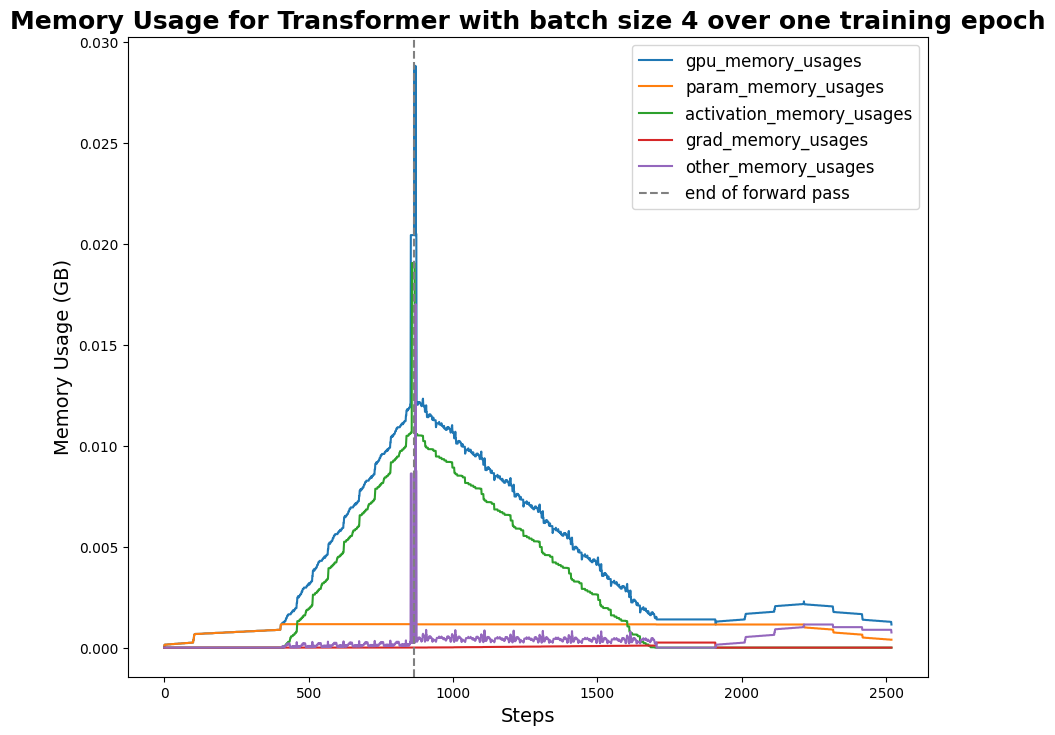

/data/healthy-ml/scratch/maanas/CS265-mlsys-project/graph_tracer.py:246: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with _enable_compile(), torch.autograd.detect_anomaly(check_nan=False):


Found optimizer node during initialization
ProfilerStatistics(time_per_run=90.99372836295515)


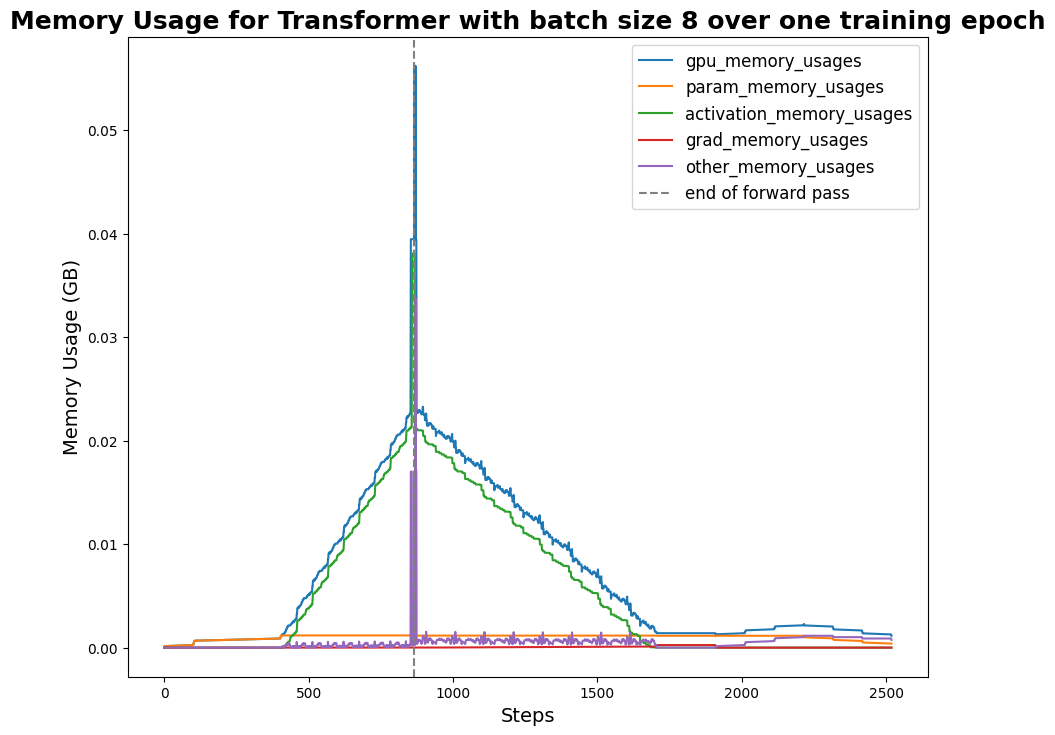

/data/healthy-ml/scratch/maanas/CS265-mlsys-project/graph_tracer.py:246: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with _enable_compile(), torch.autograd.detect_anomaly(check_nan=False):


Found optimizer node during initialization
ProfilerStatistics(time_per_run=88.82892817817628)


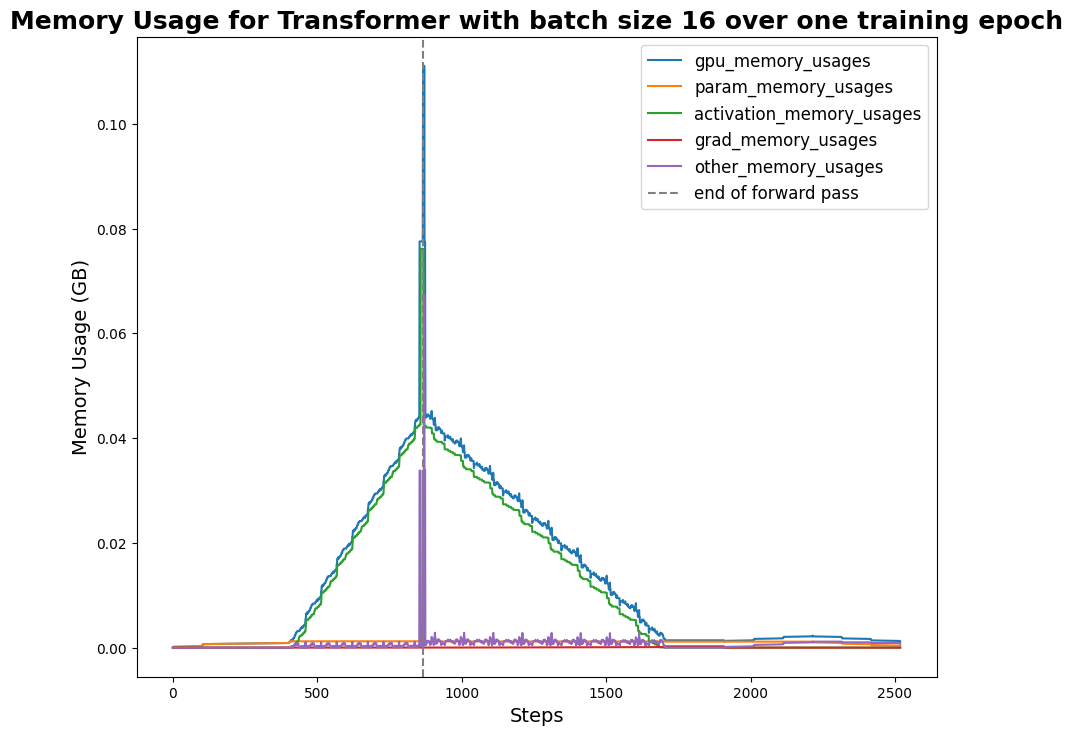

/data/healthy-ml/scratch/maanas/CS265-mlsys-project/graph_tracer.py:246: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with _enable_compile(), torch.autograd.detect_anomaly(check_nan=False):


Found optimizer node during initialization
ProfilerStatistics(time_per_run=88.42854418233037)


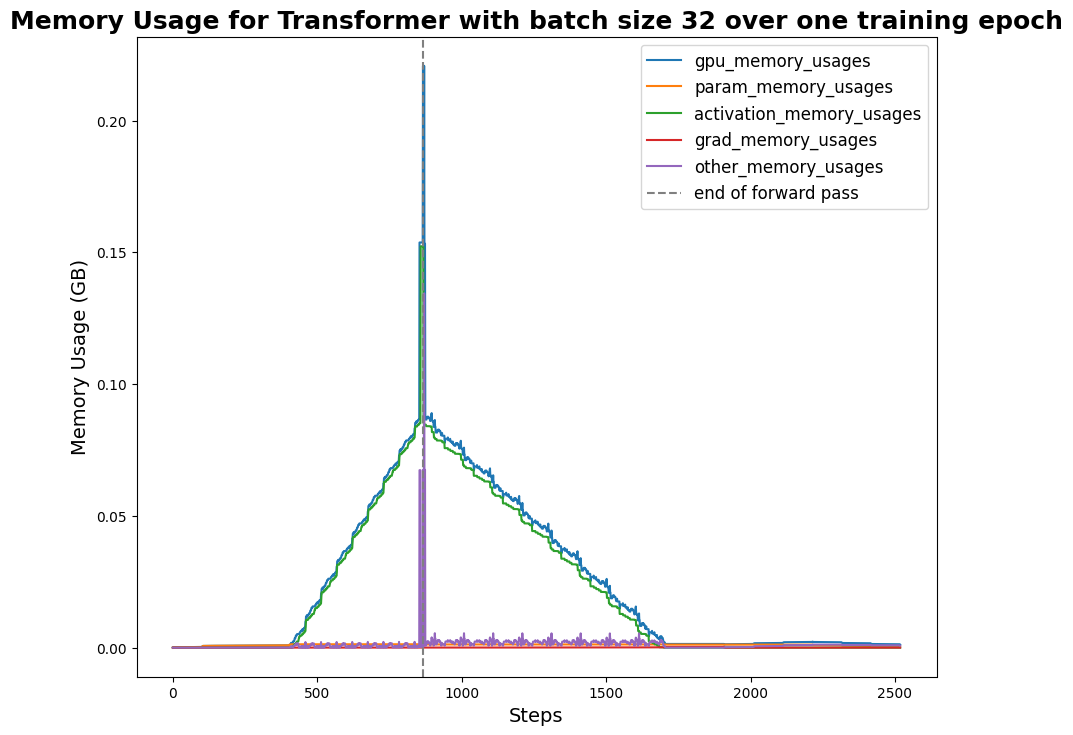

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


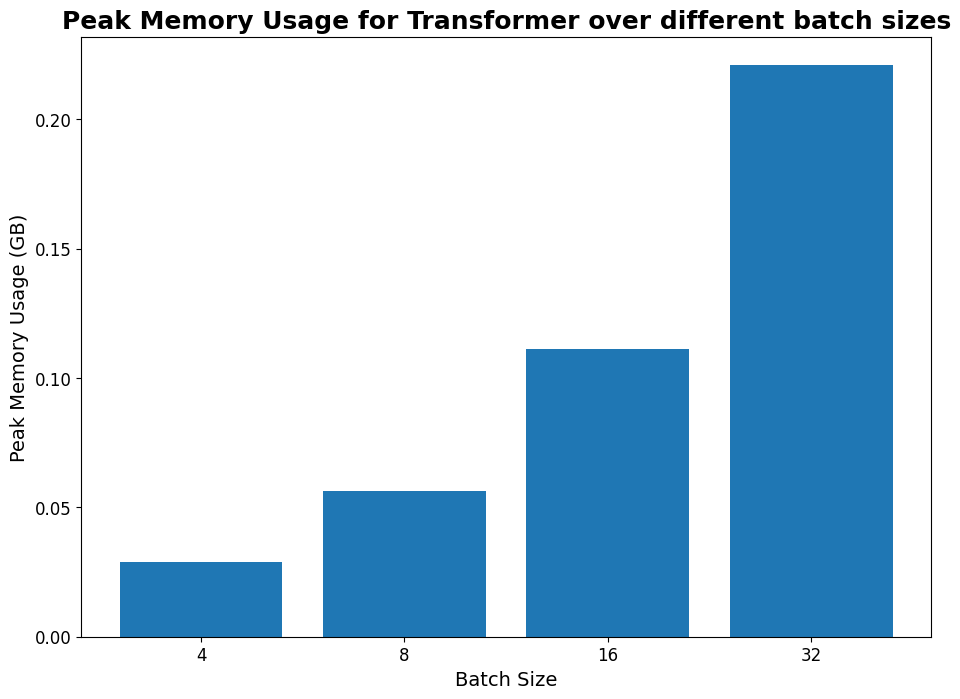

/data/healthy-ml/scratch/maanas/CS265-mlsys-project/graph_tracer.py:246: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with _enable_compile(), torch.autograd.detect_anomaly(check_nan=False):


Found optimizer node during initialization
ProfilerStatistics(time_per_run=34.49753591790795)


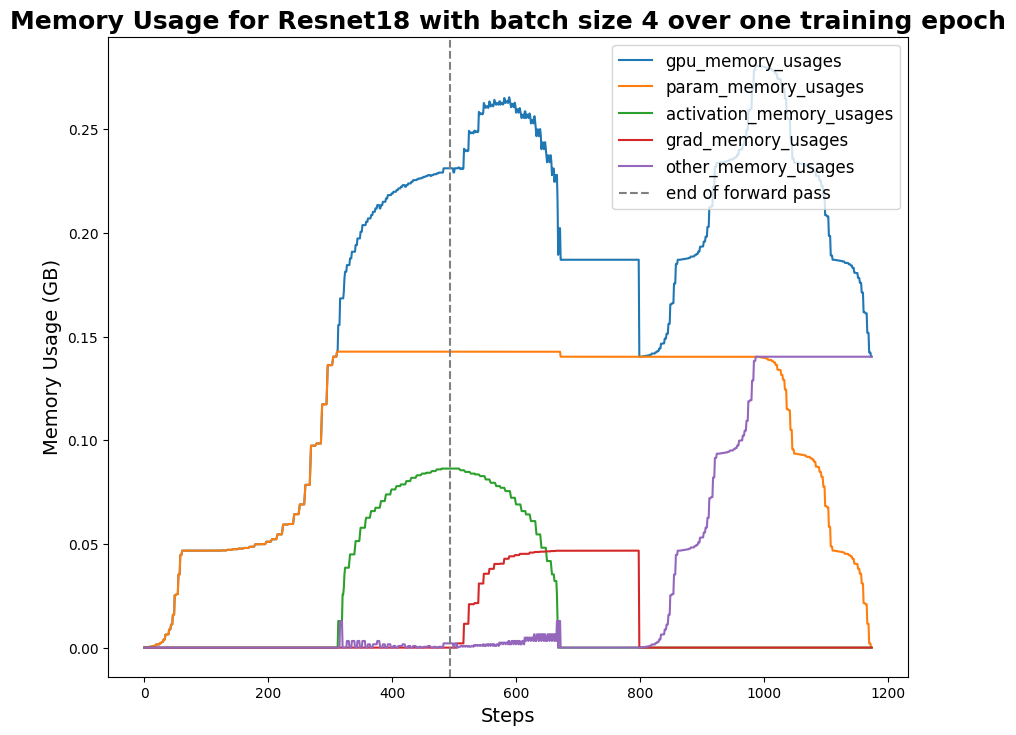

/data/healthy-ml/scratch/maanas/CS265-mlsys-project/graph_tracer.py:246: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with _enable_compile(), torch.autograd.detect_anomaly(check_nan=False):


Found optimizer node during initialization
ProfilerStatistics(time_per_run=35.86252796370536)


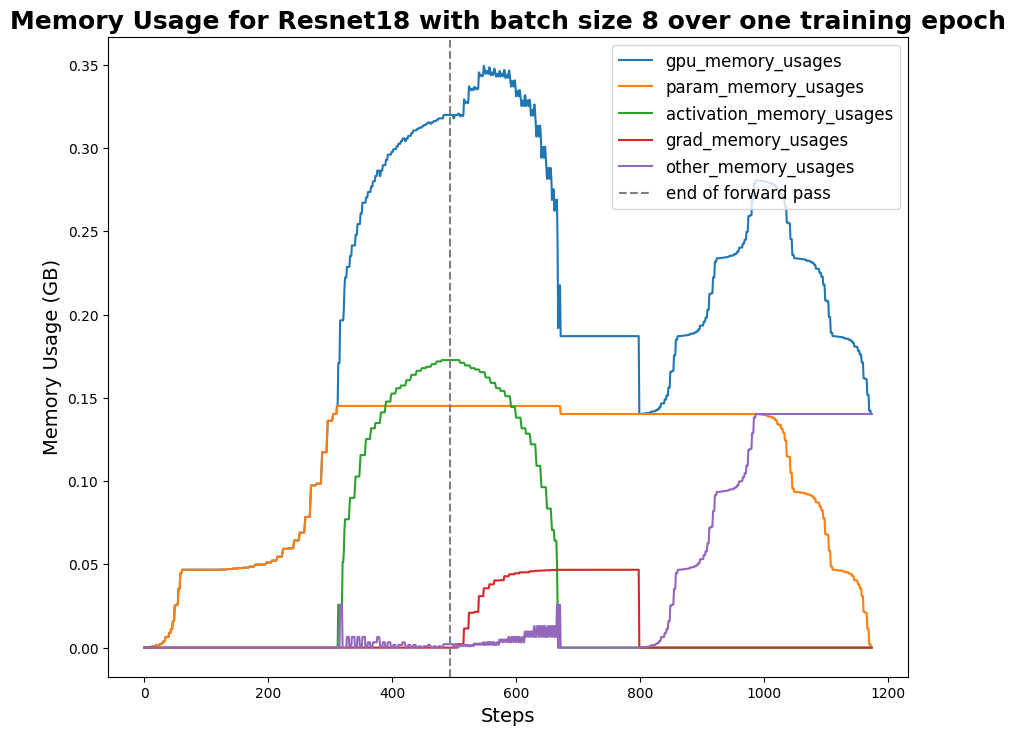

/data/healthy-ml/scratch/maanas/CS265-mlsys-project/graph_tracer.py:246: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with _enable_compile(), torch.autograd.detect_anomaly(check_nan=False):


Found optimizer node during initialization
ProfilerStatistics(time_per_run=37.721088010817766)


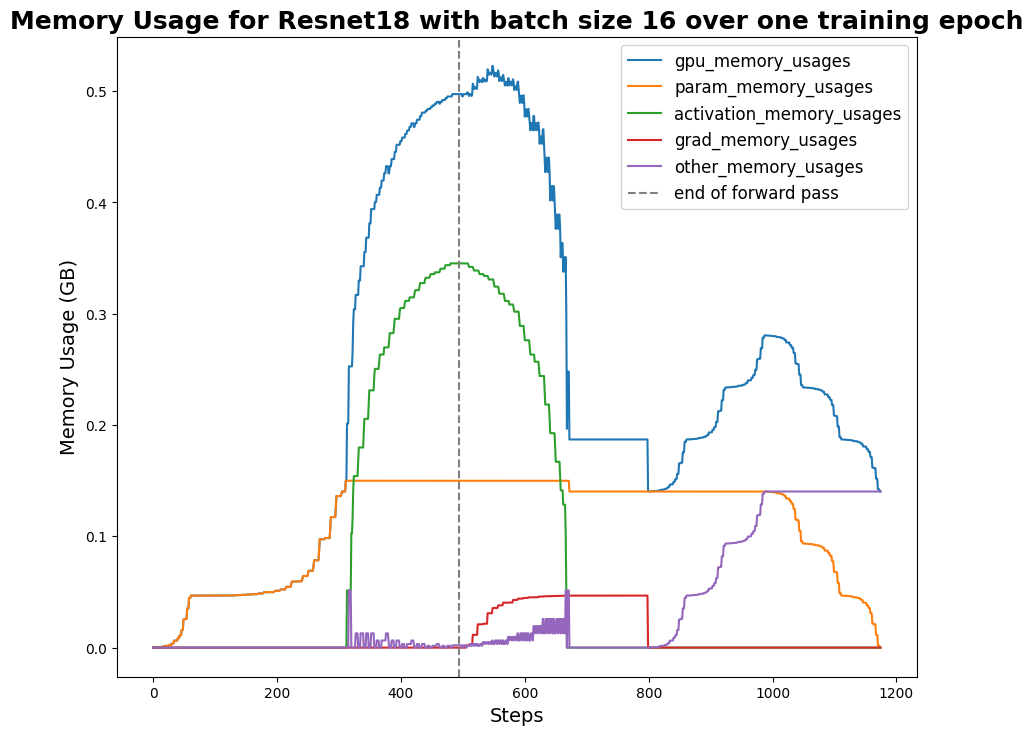

/data/healthy-ml/scratch/maanas/CS265-mlsys-project/graph_tracer.py:246: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with _enable_compile(), torch.autograd.detect_anomaly(check_nan=False):


Found optimizer node during initialization
ProfilerStatistics(time_per_run=43.3551360713318)


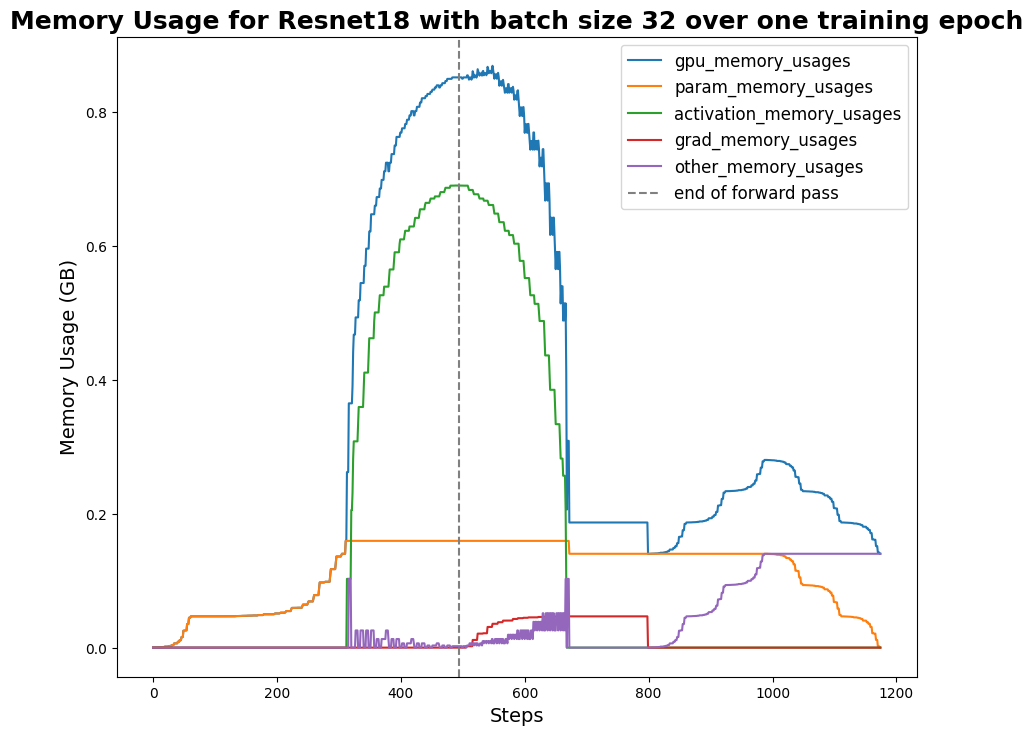

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


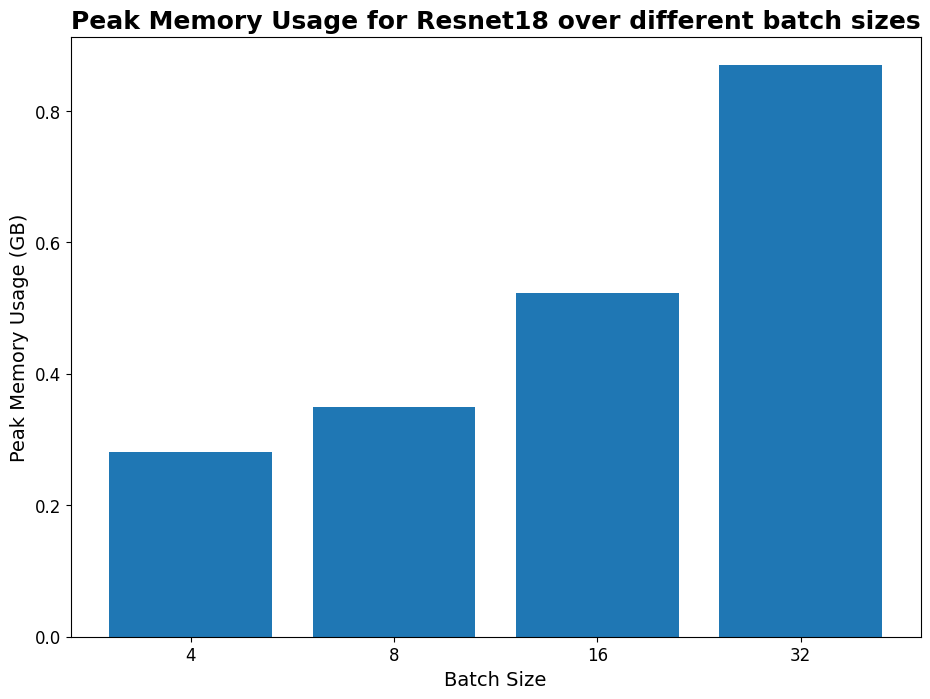

/data/healthy-ml/scratch/maanas/CS265-mlsys-project/graph_tracer.py:246: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with _enable_compile(), torch.autograd.detect_anomaly(check_nan=False):


Found optimizer node during initialization
ProfilerStatistics(time_per_run=98.97471962682903)


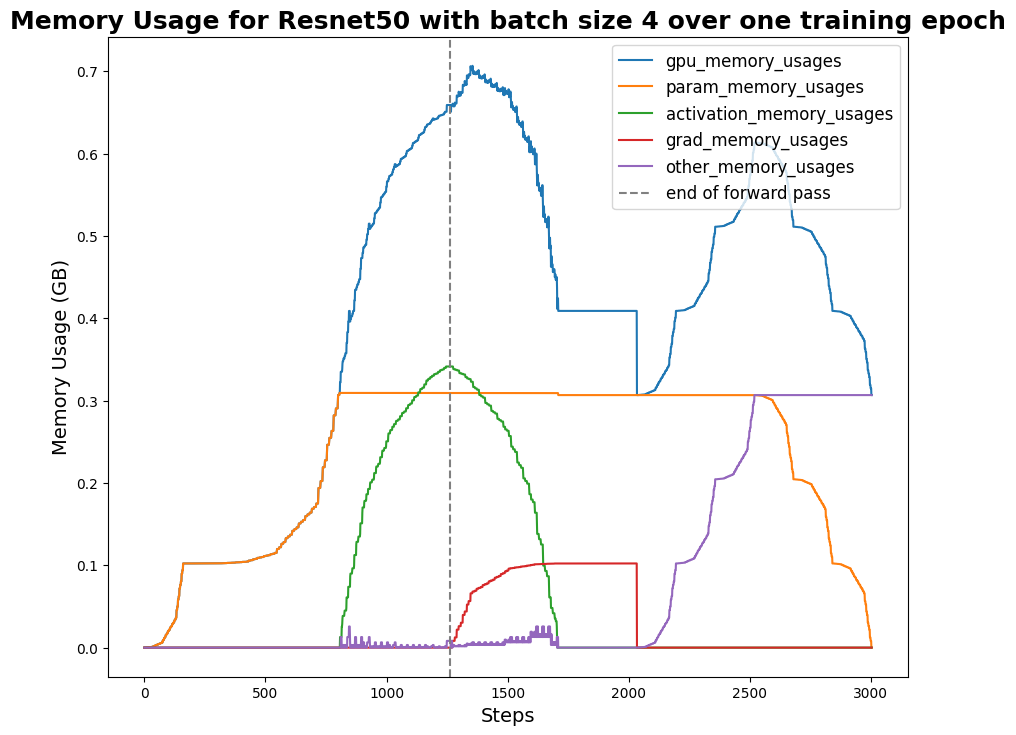

/data/healthy-ml/scratch/maanas/CS265-mlsys-project/graph_tracer.py:246: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with _enable_compile(), torch.autograd.detect_anomaly(check_nan=False):


Found optimizer node during initialization
ProfilerStatistics(time_per_run=102.33753533475101)


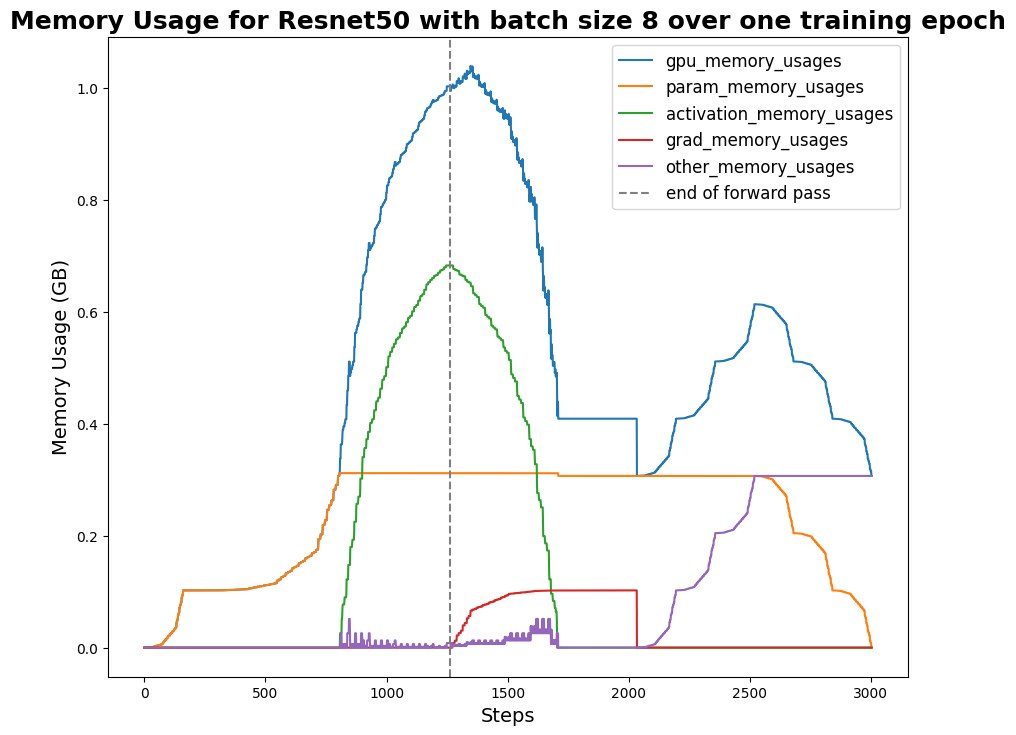

/data/healthy-ml/scratch/maanas/CS265-mlsys-project/graph_tracer.py:246: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with _enable_compile(), torch.autograd.detect_anomaly(check_nan=False):


Found optimizer node during initialization
ProfilerStatistics(time_per_run=109.58131214417517)


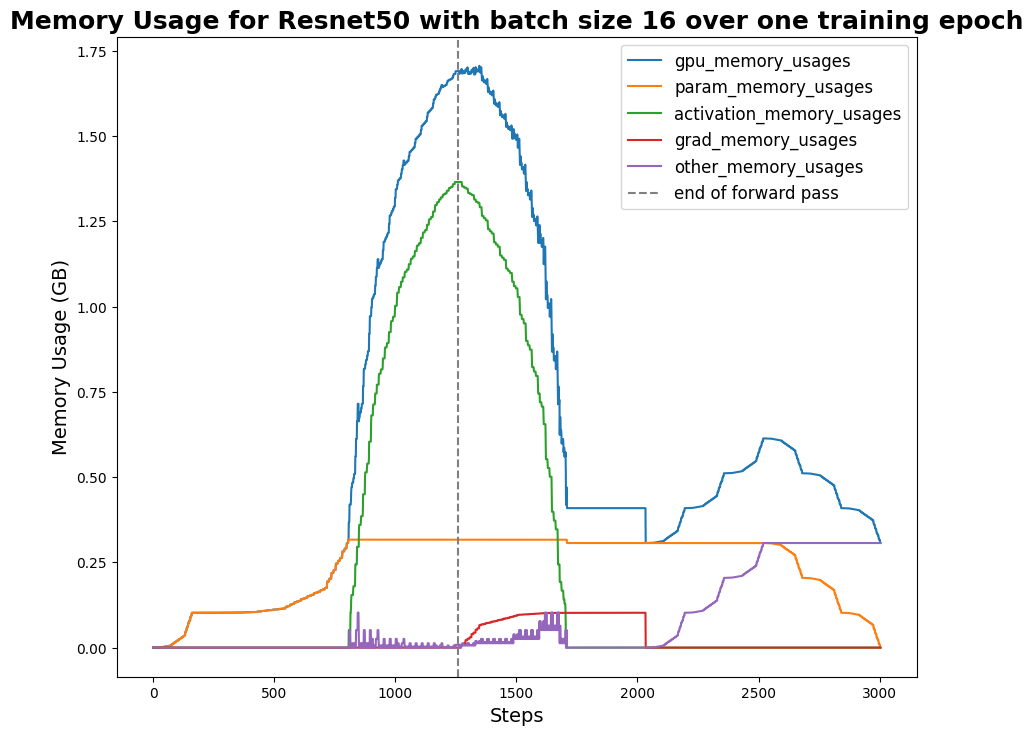

/data/healthy-ml/scratch/maanas/CS265-mlsys-project/graph_tracer.py:246: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with _enable_compile(), torch.autograd.detect_anomaly(check_nan=False):


Found optimizer node during initialization
ProfilerStatistics(time_per_run=122.40486357361078)


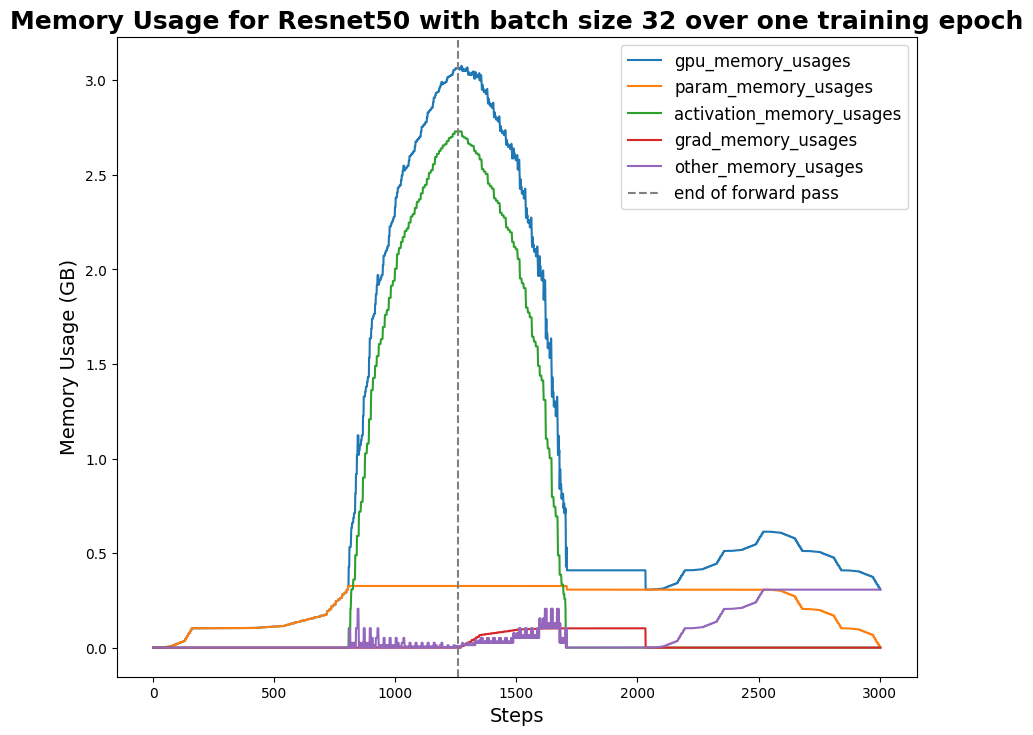

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


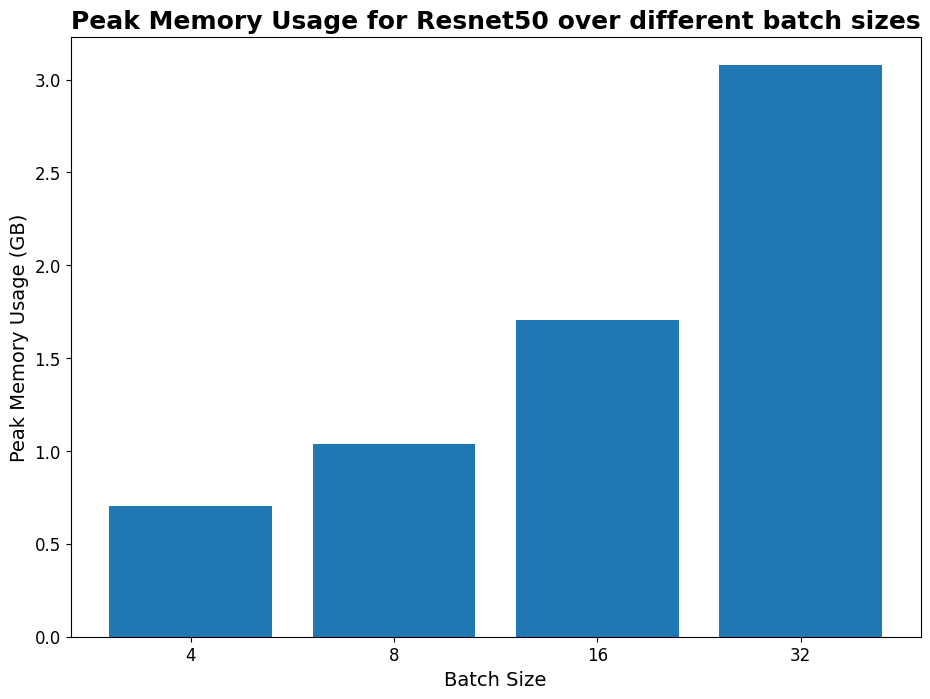

In [2]:
for model_name in model_names:
    # for batch_size in model_batch_sizes[model_name]:
    for batch_size in model_batch_sizes[model_name]:
        exp = Experiment(model_name, batch_size)
        exp.init_opt_states()
        compiled_fn = compile(exp.train_step, exp.graph_transformation)
        compiled_fn(exp.model, exp.optimizer, exp.example_inputs)

        plot_memory_usage(model_name, batch_size)
    
    plot_memory_usage_versus_batch_size(model_name)